# 1. Classifying Images with Deep Convolutional Neural Networks
## Basic imports and checks

In [2]:
import tensorflow as tf
import numpy as np

print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)

TensorFlow version: 2.0.0
NumPy version:  1.18.1


## 1. Naive implementation for computing convolutions in one dimension

In [3]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


## 2. Naive implementation for computing convolutions in two dimensions

In [4]:
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## 3. Reading an image file
- Notice that the data has 3 dimensions, the third being 3 RGB channels
### 1. Using TensorFlow functions

In [5]:
import tensorflow as tf

img_raw = tf.io.read_file('data/example-image.png')
img = tf.image.decode_image(img_raw)
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


### 2. Using imageio package

In [6]:
import imageio

img = imageio.imread('data/example-image.png')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


## 4. Regularizing a neural network with dropout
- The effect of this random dropout is that the network is forced to learn a redundant representation of the data. Therefore, the network cannot rely on an activation of any set of hidden units, since they may be turned off at any time during training, and is forced to learn more general and robust patterns from the data // book quote
- Dropout can be interpreted as the consensus (averaging) of an ensemble models, it is essentially a more efficient way of training multiple models and averaging predictions
- The relationship between model ensembles and dropout is not immediately obvious
- However, consider that in dropout, we have different model for each mini-batch (due to setting weights to zero randomly during each forward pass)
### 1. Regularization with the usual L1 and L2 is also available

In [7]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

## 6. Using different loss functions (with probabilities or logits)
### 1. Binary Crossentropy

In [8]:
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (w Probas): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))

BCE (w Probas): 0.3711 (w Logits): 0.3711


### 2. Categorical Crossentropy

In [9]:
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print(
    'CCE (w Probas): {:.4f}'.format(
    cce_probas(y_true=[0, 0, 1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    cce_logits(y_true=[0, 0, 1], y_pred=logits)))

CCE (w Probas): 0.5996 (w Logits): 0.5996


### 3. Sparse Categorical Crossentropy

In [10]:
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (w Probas): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

Sparse CCE (w Probas): 0.5996 (w Logits): 0.5996


# 2. Implementing a deep convolutional neural network using TensorFlow
## Imports

In [11]:
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load the data

In [13]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


## 2. Preprocess the data
- We meed to split the training dataset into the training and validation datasets

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

## 3. Configuring CNN layers in Keras

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

## 4. Constructing a CNN in Keras
### 1. Adding the convolution and pooling layers

In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

### 2. Computing the output shape of this part of the CNN
- We can compute the size of the feature maps using Keras API
- The output shape (16, 7, 7, 64) indicates feature maps with 64 channels and a spatial size of 7x7

In [16]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

### 3. Adding a flattening layer
- The next layer we want to add is a dense (or fully connected) layer for implementing a classifier on top of our convolutional and pooling layers
- Thus, we need to flatten the output of the previous layers to meet this requirement for the dense layer // book quote

In [17]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

### 4. Adding dense layers and a dropout layer in between

In [18]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

### 5. Building the model
- We call the build() method for late variable creation

In [19]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  832       
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
fc_1 (Dense)                 multiple                  3212288   
_________________________________________________________________
dropout (Dropout)            multiple                  0

### 6. Compile and fit the model
- Using designated methods for training and evaluation (like evaluate() and predict()) will automatically set the mode for the dropout layer and rescale the hidden units appropriately so that we do not have to worry about that at all

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 113s 144ms/step - loss: 0.1384 - accuracy: 0.9569 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
782/782 [==============================] - 96s 123ms/step - loss: 0.0454 - accuracy: 0.9864 - val_loss: 0.0473 - val_accuracy: 0.9860
Epoch 3/20
782/782 [==============================] - 96s 123ms/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.0416 - val_accuracy: 0.9891
Epoch 4/20
782/782 [==============================] - 95s 122ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0410 - val_accuracy: 0.9884
Epoch 5/20
782/782 [==============================] - 96s 123ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 0.0382 - val_accuracy: 0.9899
Epoch 6/20
782/782 [==============================] - 95s 121ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.0412 - val_accuracy: 0.9886
Epoch 7/20
782/782 [==============================] - 95s 121ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0407

### 7. Visualize the learning curves

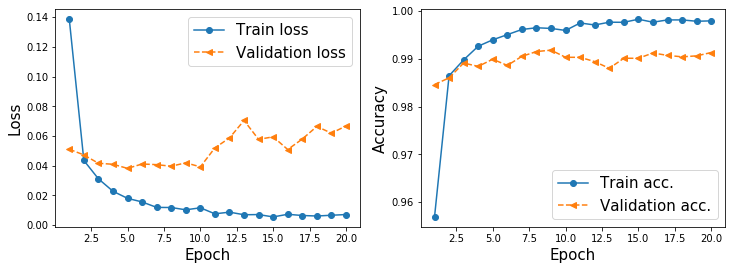

In [22]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

### 8. Evaluate the trained model on the test dataset

In [23]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 6s 11ms/step - loss: 0.0462 - accuracy: 0.9920

Test Acc. 99.20%


### 9. Convert a batch of class-membership probabilities to predicted labels and visualize the input and the corresponding predicted labels

TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


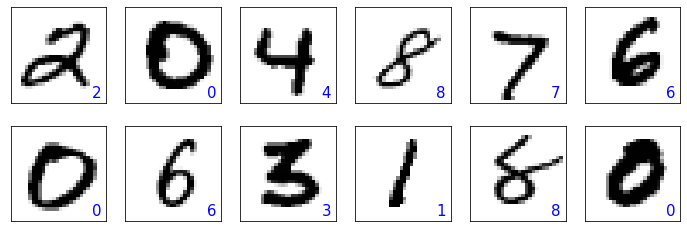

In [24]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

### 10. Save the model on a disk

In [25]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')